# Circle Classifier

In [1]:
from sklearn import datasets
import pennylane as qml
import numpy as np
from pennylane.optimize import AdamOptimizer
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Step 1 prepare data

In [125]:
X_train, Y_train = datasets.make_circles(n_samples=200, noise=0.09, factor=0.4)
X_test, Y_test = datasets.make_circles(n_samples=50, noise=0.09, factor=0.4)

### - 1.1 Plot origin data

In [126]:
print('Training Data:')
print(X_train[:10])
print('\nTraining Label:')
print(Y_train[:10])

Training Data:
[[-0.12536934 -0.49941733]
 [ 1.17819796  0.2128775 ]
 [-0.38109381 -0.26470696]
 [ 0.23199457 -0.3719473 ]
 [-0.04400952 -0.50581986]
 [ 0.90390106  0.11685939]
 [ 0.80913788  0.66202266]
 [-0.37438931 -0.74544233]
 [-0.49892585  1.00245264]
 [-0.53009833  0.80738376]]

Training Label:
[1 0 1 1 1 0 0 0 0 0]


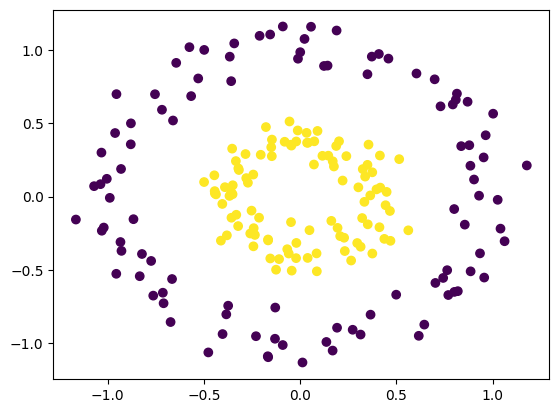

In [127]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train)
plt.show()

In [128]:
print(f'Total datas: {len(X_train)}')
print(f'labels: {list(set(Y_train))}')
print(f'label 0 datas: {len(list(filter(lambda x: x==0, Y_train)))}')
print(f'label 1 datas: {len(list(filter(lambda x: x==1, Y_train)))}')

Total datas: 200
labels: [0, 1]
label 0 datas: 100
label 1 datas: 100


### - 1.2 Add new dimention datas

In [129]:
Z_train = (X_train[:, 0] ** 2 + X_train[:, 1] ** 2) ** 0.5
temp = np.zeros((X_train.shape[0], len(X_train[0]) + 1))
temp[:, :-1] = X_train
temp[:, -1] = Z_train
X_train2 = temp

Z_test = (X_test[:, 0] ** 2 + X_test[:, 1] ** 2) ** 0.5
temp = np.zeros((X_test.shape[0], len(X_test[0]) + 1))
temp[:, :-1] = X_test
temp[:, -1] = Z_test
X_test2 = temp

print('Solved Training Data:')
print(X_train2[:10])

Solved Training Data:
[[-0.12536934 -0.49941733  0.51491276]
 [ 1.17819796  0.2128775   1.19727493]
 [-0.38109381 -0.26470696  0.46400675]
 [ 0.23199457 -0.3719473   0.43836774]
 [-0.04400952 -0.50581986  0.5077308 ]
 [ 0.90390106  0.11685939  0.91142374]
 [ 0.80913788  0.66202266  1.04545594]
 [-0.37438931 -0.74544233  0.83417721]
 [-0.49892585  1.00245264  1.11974921]
 [-0.53009833  0.80738376  0.96585339]]


In [130]:
def plot3D(X, Y):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(
        X[:, 0], X[:, 1], X[:, 2], 
        zdir='z', s=30, c=Y, depthshade=True
    )
    plt.show()

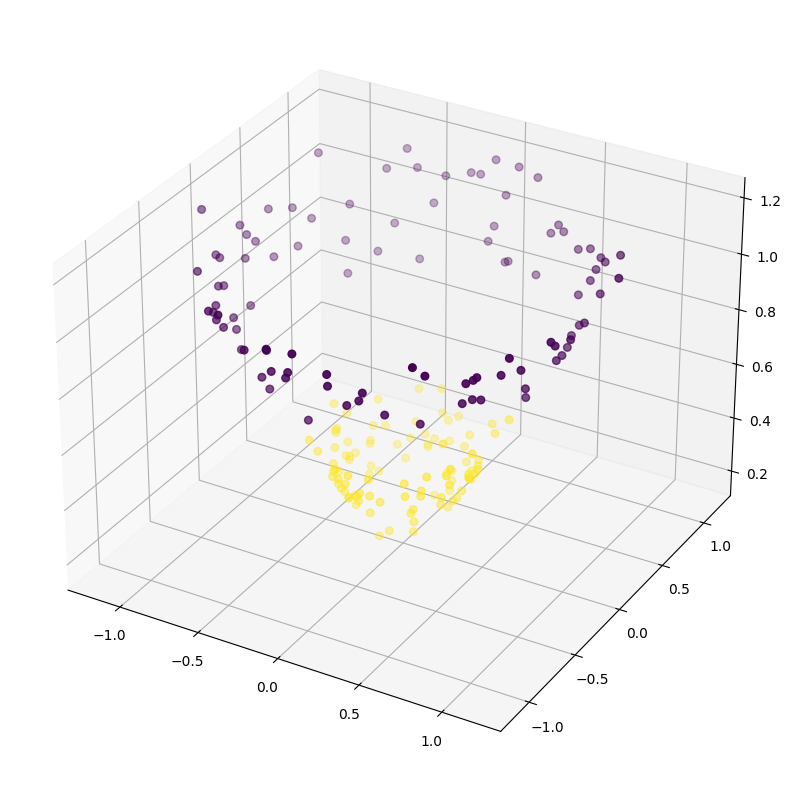

In [131]:
plot3D(X_train2, Y_train)

In [132]:
print(f'Total datas: {len(X_train2)}')
print(f'labels: {list(set(Y_train))}')
print(f'label 0 datas: {len(list(filter(lambda x: x==0, Y_train)))}')
print(f'label 1 datas: {len(list(filter(lambda x: x==1, Y_train)))}')

Total datas: 200
labels: [0, 1]
label 0 datas: 100
label 1 datas: 100


## Step 2 train model

In [133]:
qubits_num = 3
layers_num = 2

dev = qml.device("default.qubit", wires=qubits_num)

### - 2.1 Classifier

In [134]:
class VQC:
    def __init__(self):
        # 3 => U3(theta, phi, lambda)
        self.params = (0.05 * np.random.randn(layers_num, qubits_num, 3))
        self.bestparams = self.params
        self.bestcost = 10
        
        self.opt = AdamOptimizer(0.08)
        
        self.weights = []
        self.costs = []
        self.accuracies = []
        
    def fit(self, X_train, Y_train, epoch=300):
        batch_size = 20

        for turn in range(epoch):
            # Update the weights by one optimizer step
            batch_index = np.random.randint(0, len(X_train), (batch_size,))
            X_train_batch = X_train[batch_index]
            Y_train_batch = Y_train[batch_index]
            self.params = self.opt.step(lambda v: cost(v, X_train_batch, Y_train_batch), self.params)

            cost_now = cost(self.params, X_train, Y_train)
            acc_now = accuracy(self.params, X_train, Y_train) 

            if cost_now < self.bestcost:
                self.bestcost = cost_now
                self.bestparams = self.params
            
            self.weights.append(self.params)
            self.costs.append(cost_now)
            self.accuracies.append(acc_now)
            
            print(
                "Turn: {:5d} | Cost: {:0.7f} | Accuracy: {:0.2f}% ".format(
                turn + 1, cost_now, acc_now * 100
            ))
            
    def score(self, X_test, Y_test):
        predictions = [ predict(self.bestparams, data) for data in X_test ]
        acc = accuracy(self.bestparams, X_test, Y_test)
        
        print("FINAL ACCURACY: {:0.2f}%".format(acc * 100))

### - 2.2 Circuit object

In [135]:
@qml.qnode(dev)
def circuit(params, data):
    angles = [ i  * np.pi for i in data ]

    for i in range(qubits_num):
        qml.RX(angles[i], wires=i)
        qml.Rot( *params[0, i], wires=i )

    qml.CZ(wires=[1, 0])
    qml.CZ(wires=[1, 2])
    qml.CZ(wires=[0, 2])

    for i in range(qubits_num):
        qml.Rot( *params[1, i], wires=i )
    
    # PauliZ measure => 1 -> |0>  while -1 -> |1>
    return qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliZ(1)), qml.expval(qml.PauliZ(2))

### - 2.3 Prediction

In [136]:
import qiskit
import numpy as np
from qiskit import QuantumCircuit
from qiskit import Aer, execute

unitary_backend = Aer.get_backend('unitary_simulator')
qasm_backend = Aer.get_backend('qasm_simulator')

In [137]:
def predict(params, data):
    qcircuit = QuantumCircuit(3, 3)
    qubits = qcircuit.qubits

    for i, d in enumerate(data):
        qcircuit.rx(d * np.pi, qubits[i])
        
    for i in range(qubits_num):
        qcircuit.u3(*params[0][i], qubits[i])

    qcircuit.cz(qubits[0], qubits[1])
    qcircuit.cz(qubits[1], qubits[2])
    qcircuit.cz(qubits[0], qubits[2])

    for i in range(qubits_num):
        qcircuit.u3(*params[1][i], qubits[i])
    
    # the measurement
    qcircuit.measure([0, 1, 2], [0, 1, 2])

    # job execution
    shots = 1000
    job_sim = execute(qcircuit, qasm_backend, shots=shots)
    result_sim = job_sim.result()
    counts = result_sim.get_counts(qcircuit)

    p1 = (counts.get('100', 0) + counts.get('111', 0) + counts.get('101', 0) + counts.get('110', 0)) / shots
    
    if p1 > 0.5:
        return 1
    else:
        return 0

### - 2.4 Loss and accuracy

In [138]:
def cost(weights, datas, labels):
    loss = 0
    
    for i, data in enumerate(datas):
        # like [-1, 1, 1]
        measured = circuit(weights, data)

        p = measured[0]
        if labels[i] == 0:
            loss += (1 - p) ** 2
        else:
            loss += (-1 - p) ** 2
        
    return loss / len(datas)

In [139]:
def accuracy(weights, datas, labels):
    predictions = [ predict(weights, data) for data in datas ]
    
    acc = 0
    for i, p in enumerate(predictions):
        if p == labels[i]:
            acc += 1
    
    return acc / len(predictions)

### - 2.5 Train model

In [140]:
vqc = VQC()

In [141]:
# vqc.params = np.array([[[-1.18991246e-01, -8.69694713e-01,  1.43722811e-03],
#       [ 3.47641545e+00, -4.73632073e-02,  1.97135609e+00],
#       [ 1.95775707e+00, -1.12139160e-02, -6.21796144e-03]],

#      [[ 2.02460380e-02, -2.25797547e+00,  5.14234265e-03],
#       [-1.71552299e-02,  2.46283604e-03, -1.03805722e-02],
#       [-2.37244982e-03, -3.35799404e-03,  6.10191152e-03]]])

In [142]:
vqc.fit(X_train2, Y_train, epoch=10)

Turn:     1 | Cost: 0.9129685 | Accuracy: 92.50% 
Turn:     2 | Cost: 0.9129685 | Accuracy: 92.00% 
Turn:     3 | Cost: 0.9129685 | Accuracy: 92.50% 
Turn:     4 | Cost: 0.9129685 | Accuracy: 94.00% 
Turn:     5 | Cost: 0.9129685 | Accuracy: 92.50% 
Turn:     6 | Cost: 0.9129685 | Accuracy: 93.50% 
Turn:     7 | Cost: 0.9129685 | Accuracy: 93.00% 
Turn:     8 | Cost: 0.9129685 | Accuracy: 93.50% 
Turn:     9 | Cost: 0.9129685 | Accuracy: 94.50% 
Turn:    10 | Cost: 0.9129685 | Accuracy: 92.50% 


In [143]:
print(cost(vqc.bestparams, X_train2, Y_train))
print(cost(vqc.bestparams, X_test2, Y_test))

0.9129685064211677
0.8949712148939472


In [144]:
vqc.score(X_test2, Y_test)

FINAL ACCURACY: 96.00%


## Step 3 Validate and Analysis

### - 3.1 create quantum circuit

In [145]:
def createCircuit(params, data):
    qcircuit = QuantumCircuit(3, 3)
    qubits = qcircuit.qubits

    for i, d in enumerate(data):
        qcircuit.rx(d * np.pi, qubits[i])

    for i in range(qubits_num):
        qcircuit.u3(*params[0][i], qubits[i])

    qcircuit.cz(qubits[0], qubits[1])
    qcircuit.cz(qubits[1], qubits[2])
    qcircuit.cz(qubits[0], qubits[2])

    for i in range(qubits_num):
        qcircuit.u3(*params[1][i], qubits[i])
        
    return qcircuit

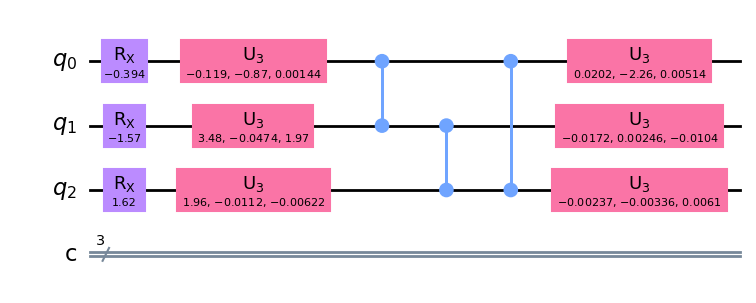

In [146]:
qcircuit = createCircuit(vqc.bestparams, X_train2[0])
qcircuit.draw(output='mpl')

### - 3.2 measure results

In [147]:
def measure(qcircuit, label):
    # the measurement
    qcircuit.measure([0, 1, 2], [0, 1, 2])

    # job execution
    shots = 1000
    job_sim = execute(qcircuit, qasm_backend, shots=shots)
    result_sim = job_sim.result()
    counts = result_sim.get_counts(qcircuit)

    print(f'simulation results: \n{counts}')
    p1 = (counts.get('100', 0) + counts.get('111', 0) + counts.get('101', 0) + counts.get('110',0)) / shots
    print(f'p1: {p1}')
    print(f'Expected label: {label}')

In [153]:
example = [3, 30, 35, 70]

for index in example:
    qcircuit = createCircuit(vqc.bestparams, X_train2[index])
    measure(qcircuit, Y_train[index])
    print()

simulation results: 
{'010': 323, '000': 73, '110': 387, '101': 15, '100': 80, '111': 55, '011': 63, '001': 4}
p1: 0.537
Expected label: 1

simulation results: 
{'010': 195, '110': 208, '111': 87, '001': 73, '100': 154, '011': 86, '000': 143, '101': 54}
p1: 0.503
Expected label: 1

simulation results: 
{'111': 277, '011': 633, '001': 59, '110': 3, '101': 19, '010': 8, '100': 1}
p1: 0.3
Expected label: 0

simulation results: 
{'000': 471, '100': 191, '101': 110, '001': 217, '010': 4, '011': 3, '110': 4}
p1: 0.305
Expected label: 0



### - 3.3 Mispredict data

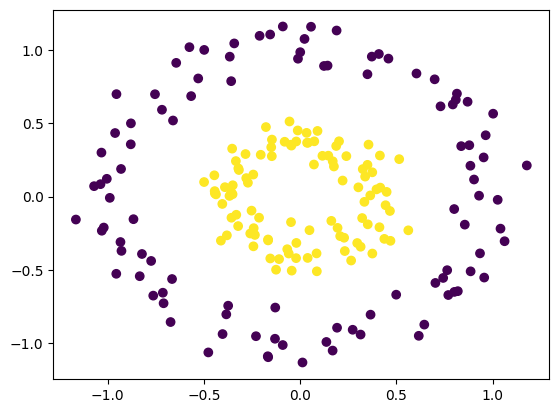

In [154]:
# origin data
plt.scatter(X_train2[:, 0], X_train2[:, 1], c=Y_train)
plt.show()

In [155]:
predictions = [ predict(vqc.bestparams, data) for data in X_test2 ]
Y_ = [ Y_test[i] if Y_test[i] == predictions[i] else 2  for i in range(len(Y_test)) ]

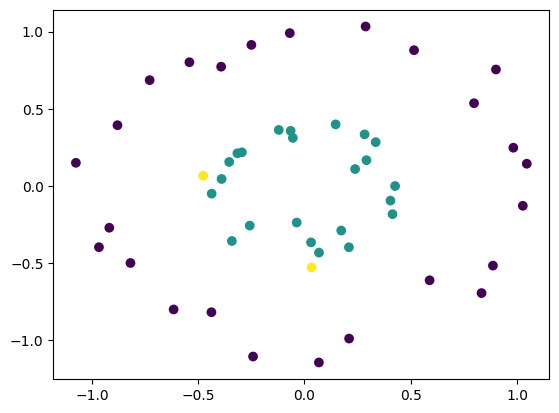

In [156]:
plt.scatter(X_test2[:, 0], X_test2[:, 1], c=Y_)
plt.show()

In [169]:
train_params(X_train2[10:50], Y_train[10:50])

(1.5851444072688277,
 array([ 2.90436517, -3.3929822 , -3.01835489, -3.03307662, -2.31179662,
        -1.07932334, -1.89268293, -0.39784896, -1.75777057]))